# <center>**Classification of Unraveled Spirals**<center>

#### **Goal:** obtain a distance error between the misclassified hand drawn spirals and a LOBF ("ideal") spiral

Any functions / processes that require the use of tensorflow or keras need to be in this file. Other functions can be in a seperate python file. 

## **Process**
1. Import the skeletonized images
    - Convert to grayscale
    - Save all images in an array with the corresponding labels
2. Unravel all of the spirals
    - Normalize so they all have the same length
        - Do this by zero-padding?
3. Perform spline fitting
    - Subtract the spline from hand-drawing
    - This is the "deviation signal"
    - Convert to the frequency domain
        - Take the fft
        - Plot the magnitude of a couple of the spirals
5. Extract features
    - Need to decide what will be passed in as features for classification
        - variance, SNR, bandwidth, peaks, center freq?
6.  Run features through classifiers
    - RF, SVM, NB, KNN


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import warnings
import seaborn as sns

# import ML libraries
from sklearn import utils, svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.interpolate import UnivariateSpline 
from scipy import interp
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV, LogisticRegression

# import files with certain functions
from code_files.archSpiral import * # functions of interest are 'unravelSpiral' and 'calcDist_to_center' 

warnings.filterwarnings('ignore')

## <center>Step 1: Import Skeletonized Images<center>

size of imgs array:  (352, 1000, 1000)
size of lbls array:  (352,)
Healthy:  176 , PD:  176


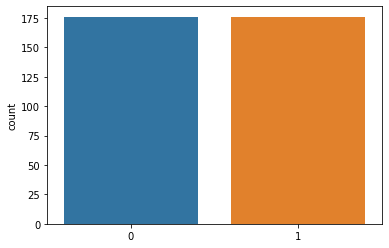

In [23]:
dir = os.getcwd()
folder_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/skel/spiral' #dir + '/datasets/folador_skeletonize/skeletons/spirals/'
run_balanced = True
imgs = [] # create empty array to store all the images
lbls = [] # create empty array to store the labels of the images
img_names = []
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    
    # convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img[img > 50] = 255
    img[img != 255] = 0

    # save the labels in 'lbls' array
    # need to determine if it is healthy or parkinsons based on 'H' or 'P' being present in the file name
    if 'H' in img_name:
        if run_balanced:
            if len(lbls)-np.count_nonzero(lbls) < 176:
                lbls.append(0)
                # save image in 'imgs' array
                imgs.append(img)
        else:
            lbls.append(0)
            # save image in 'imgs' array
            imgs.append(img)

    else:
        lbls.append(1)
        # save image in 'imgs' array
        imgs.append(img)

    img_names.append(img_name)

# shuffle the data
# imgs, lbls = utils.shuffle(imgs, lbls)

print("size of imgs array: ", np.shape(imgs))
print("size of lbls array: ", np.shape(lbls))

# plot the distribution of labls
sns.countplot(lbls)
print("Healthy: ", len(lbls)-np.count_nonzero(lbls), ", PD: ", np.count_nonzero(lbls))

## <center>Step 2: Unravel Spirals<center>

In [24]:
numImgs = len(imgs)
unraveledSpirals = [] # create empty array to store unraveled spirals

# iterate through all images and unravel
for i in range(numImgs):
    print(i, end='\r')
    center = unravelSpiral(imgs[i])
    unravelledImg = calcDist_to_center(imgs[i], center)
    unraveledSpirals.append(unravelledImg)

print(np.shape(unraveledSpirals))
# then need to normalize (do by zero padding)

(352,)


In [8]:
cv2.imshow('img', imgs[7])
cv2.waitKey()


-1

In [ ]:
plt.figure(figsize=(20,20))
plt.matshow(imgs[7], cmap='gray', fignum=1)
plt.tick_params(left=False, top=False, labelleft=False, labeltop=False)
plt.title('Skeletonized Image', pad=20, fontweight='bold')
plt.rcParams.update({'font.size':40})
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

## <center>Step 3: Perform Spline Fitting<center>

In [25]:
fftSignals = [] 

# iterate through all the unravelled spirals
# fit a spline to each spiral individually
# subtract the spline from the hand-drawing
# store this difference signal in 'deviationSignals'
for i in range(numImgs): # [7]
    print(i+1, end='\r')
    # print(img_names[i])

    hand_drawing = unraveledSpirals[i][::2]
    numSamples = np.linspace(0, len(hand_drawing)-1, len(hand_drawing))    

    pad_width = 3750 - len(hand_drawing)
    pad_array = np.ones(pad_width).astype(np.int) 


    # calculate the line-of-best-fit (LOBF) or "spline"
    # print('numSamples: ', len(numSamples))
    smoothing_factor = len(numSamples)*25
    # print('smoothing_factor: ', smoothing_factor)
    spl = UnivariateSpline(numSamples, hand_drawing, s=smoothing_factor, k=3)
    lobf = spl(numSamples)

    # plt.plot(hand_drawing)
    # plt.plot(lobf)
    # plt.show()

    # take the difference
    diff = hand_drawing - lobf
    diff_x = np.append(diff, (pad_array * 0))
    
    # take the magnitude of the fft to convert to the frequency domain
    diff = (np.abs(np.fft.fftshift(np.fft.fft(diff_x)) / 3750))
    mean = np.mean(diff)
    # diff = np.append(diff, (pad_array * mean))

    fftSignals.append(diff)
    
    # xaxis0 = np.linspace(0, 3750-1, 3750)
    # xaxis12 = np.linspace(-1875, 1875, 3750)
    # yaxis = np.append(hand_drawing, pad_array)
    # lobf = np.append(lobf, pad_array)

    # fig, ax = plt.subplots(1,3,figsize=(35,7))
    # # ax[0].plot(xaxis0, yaxis, label="Hand Drawn Spiral (orig)", color='b')
    # # ax[0].plot(xaxis0, lobf, label="Line-of-Best Fit (lobf)", color='r',  alpha=.4, linewidth=3)
    # ax[0].plot(xaxis0, diff_x, color='b', linewidth=1)
    # # ax[0].set_title('Unraveled Signal', loc='center', fontweight='bold')
    # # ax[0].set_ylabel('Distance to Center', labelpad=10)
    # # ax[0].set_xlabel('Number of Pixels', labelpad=10) 
    # ax[0].set_title('Tremor Deviation', loc='center', fontweight='bold')
    # ax[0].set_ylabel('orig - lobf', labelpad=10)
    # ax[0].set_xlabel('Number of Pixels', labelpad=10) 
    # # ax[0].legend(loc="lower right")
    # ax[1].plot(xaxis12[1875:3750], diff[1875:3750], color='k', linewidth=1)
    # ax[1].set_title('FFT Magnitude Plot', loc='center', fontweight='bold')
    # ax[1].set_ylabel('Magnitude', labelpad=10)
    # ax[1].set_xlabel('Frequency', labelpad=10)
    # ax[2].plot(xaxis12[1875:2175], diff[1875:2175], color='k', linewidth=1)
    # ax[2].set_title('FFT Magnitude Plot (center zoomed)', loc='center', fontweight='bold')
    # ax[2].set_ylabel('', labelpad=10)
    # ax[2].set_xlabel('Frequency', labelpad=10)
    # plt.rcParams.update({'font.size':30})
    # plt.rcParams.update({'font.family': 'Times New Roman'})
    # plt.show()

    # plt.figure(figsize=(18,10))
    # plt.plot(xaxis0, yaxis, label="Hand-Drawn Spiral (orig)", color='b', linewidth=2)
    # plt.plot(xaxis0, lobf, label="Line-of-Best-Fit (lobf)", color='r',  alpha=.5, linewidth=4)
    # plt.legend(loc='upper right')
    # plt.xlabel('Number of Pixels')
    # plt.ylabel('Distance to Center')
    # plt.title('Unraveled Spiral', fontweight='bold')

## <center>Step 4: Extract Features<center>

In [26]:
# SNR, variance, BW, center freq, peaks

# obtain the magnitude
peaks = []
centers = []
var = []
snr = []
bw = []

for i in range(numImgs):
    sig = np.around(fftSignals[i], decimals=10) # round the values to 10 decimal places
    max = np.max(sig) # calculate the peak

    # find the "center freq" location
    peak_loc = np.argwhere(sig == max) 
    # center_loc = peak_loc[0] + int((peak_loc[1] - peak_loc[0])/2)
    center_loc = int(peak_loc[1])

    # calculate SNR
    # seperate into noise part and signal part
    # calculate noise_floor threshold
    noise_floor = np.mean(sig)*2
    nf_approx = np.around(noise_floor,3)
    part_sig=[]
    part_noise=[]
    for samp in sig:
        if samp > nf_approx:
            part_sig.append(samp)
        else:
            part_noise.append(samp)
    # calc SNR
    #old calc
    # m_sq = np.mean(part_sig)**2
    # v    = np.var(part_noise)
    # sigSNR = m_sq / v # mean of the signal squared / variance of the noise
    #new calc
    sig_mean = np.sum(part_sig**2) / len(part_sig)
    noise_mean = np.sum(part_noise**2) / len(part_noise)
    sigSNR = (sig_mean / noise_mean) - 1

    # calculate the variance
    sigVar = np.var(part_sig)

    # calculate the bandwidth
    # this will just be the total number of signal samples
    sigBW = len(part_sig)

    peaks.append(max)
    centers.append(center_loc)
    var.append(sigVar)
    snr.append(sigSNR)
    bw.append(sigBW)

In [27]:
# plot the histogram infromation of an images
# need to load in the original images (do this based on 'image_names' and just need to remove 'skel_' from out front)
# will need to set the right folder paths to load the folders
hist = []
thresh_val=[]
orig_img_folder_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/orig/spiral/'
for i in range(numImgs):
    print(i, end='\r')
    img_name = img_names[i].replace('skel_', '')
    
    if 'H' in img_name:
        group = 'healthy/'
    else:
        group = 'parkinson/'

    path = orig_img_folder_path + group + img_name
    # path = orig_img_folder_path + 'parkinson/2_17_PE0178.jpg'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    # create the histogram
    thresh = np.mean(img)
    error = 255 - thresh
    thresh = np.around(thresh - error, 1)

    # img_content=img.copy()
    # nx = np.shape(img)[0]
    # ny = np.shape(img)[1]
    # for y in range(ny):
    #     for x in range(nx):
    #         if img_content[x][y] > thresh:
    #             img_content[x][y] = 255

    # cv2.imshow('img', img_content)
    # cv2.waitKey()

    sigHist = []
    sigThresh = thresh
    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            if img[x][y] < thresh:
                sigHist.append(img[x][y])

    hist.append(len(sigHist))
    thresh_val.append(np.mean(sigHist))

## <center>Step 5: Classification<center>

In [82]:
# first put all the features in a dataframe

# try classifying with SVM
# https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python 

In [28]:
fft_features = {'labels':lbls,'peaks': peaks, 'centers':centers, 'variance':var, 'SNR':snr, 'BW':bw, 'hist': hist, 'thresh_val': thresh_val}
fft_df = pd.DataFrame(fft_features)
fft_df = fft_df.reset_index(drop=True)
fft_df.head()

,labels,peaks,centers,variance,SNR,BW,hist,thresh_val
0,0,1.207481,1890,0.003938,1234.401595,214,4338,187.581604
1,0,0.954817,1894,0.003830,1715.411331,188,4412,181.429737
2,0,0.910544,1886,0.003992,1346.539047,200,4973,167.897044
3,0,1.208212,1886,0.003964,1063.794957,214,4598,165.204219
4,0,1.095180,1891,0.004829,1228.551334,198,5060,173.963834


In [18]:
# FUNCTION FOR FEATURE CLASSIFICATION
# SET CLASSIFIER INPUT
def freq_feature_classification(data, labels, classifier, features):  
    rs = 42 # define the random state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs) # this is approximately a 80-20 split

    if classifier == 'SVM':
        # param_grid={'C':[50, 100, 200],'degree':[5, 7, 15],'kernel':['poly']} # {'C':[1, 10, 100, 200],'degree':[2, 5, 7, 15],'kernel':['poly', 'rbf']}
        clf = svm.SVC(kernel='poly', C=100, degree=5, probability=True, random_state=rs)
        # clf = svm.SVC(probability=True, random_state=rs)
        # clf = GridSearchCV(estimator=clf, param_grid=param_grid)

    if classifier == 'RF':
        param_grid = {'n_estimators': [200], 'max_features': ['sqrt'], 'max_depth' : [10], 'criterion' :['gini'], 'random_state': [10]}
        clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=10, criterion='gini', random_state=rs)

    if classifier == 'NB':
        clf = GaussianNB()        
        
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)

    acc = []
    cfm_storage = []
    tpr_storage = []
    tnr_storage = []
    prec = []
    recall = []
    f1 = []

    i=0
    plt.figure(figsize=(8,8))
    for train, test in cv.split(data, labels):

        # print("Train - # pd labels: ", (labels.iloc[train[:]]).value_counts()[1], '# h labels: ', (labels.iloc[train[:]]).value_counts()[0])
        # print("Test - # pd labels: ", (labels.iloc[test[:]]).value_counts()[1], '# h labels: ', (labels.iloc[test[:]]).value_counts()[0])
        probas_ = clf.fit(data.iloc[train[:]], labels.iloc[train[:]]).predict_proba(data.iloc[test[:]])
        # print(clf.best_params_)
        # compute the ROC curve and area under the curve
        fpr, tpr, thresholds = metrics.roc_curve(labels.iloc[test[:]], probas_[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0]=0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)

        # predict the model
        pred = (clf.predict(data.iloc[test[:]]))

        # calculate accuracy
        acc.append(round(metrics.accuracy_score(labels.iloc[test[:]], pred),4))
        cfm = metrics.confusion_matrix(labels.iloc[test[:]], pred)
        clf_report = metrics.classification_report(labels.iloc[test[:]], pred, output_dict=True)
        cfm_storage.append(cfm)
        tpr_storage.append(cfm[0][0] / (cfm[0][0] + cfm[1][0]))
        tnr_storage.append(cfm[1][1] / (cfm[1][1] + cfm[0][1]))
        prec.append(clf_report['macro avg']['precision'])
        recall.append(clf_report['macro avg']['recall'])
        f1.append(clf_report['macro avg']['f1-score'])

        i+=1

    
    plt.plot([0,1],[0,1], linestyle='--', lw=2, color='k', label='Baseline', alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    if features==1: # frequency only
        plot_title = classifier + ' - $F_{B1}$'
    else:
        plot_title = classifier + ' - $F_{B2}$'
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title, loc='left', fontweight='bold')
    plt.legend(loc="lower right")
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'Times New Roman'})
    plt.show()

    return np.around(acc,3), np.around(cfm,3), np.around(tpr_storage,3), np.around(tnr_storage,3), np.around(prec,3), np.around(recall,3), np.around(f1,3)

In [12]:
# drop features of choice
x_train = fft_df.drop(['labels'], axis=1) # 'thresh_val', 'hist'
y_train = fft_df.labels

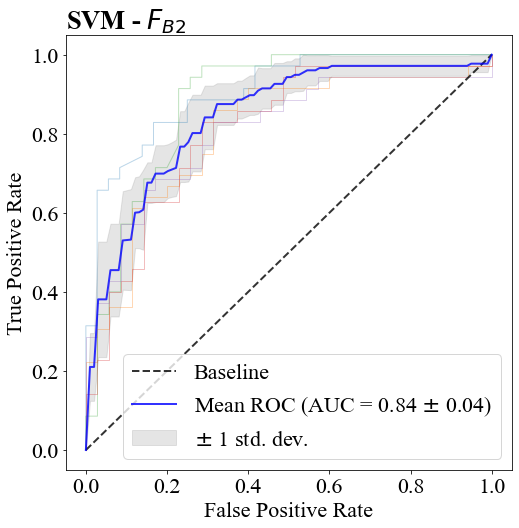

[0.803 0.718 0.757 0.714 0.714]
Accuracy - min: 0.7140, max: 0.8030, avg: 0.7412, std. dev: 0.0349
TPR - min: 0.6920, max: 0.7500, avg: 0.7124, std. dev: 0.0223
TNR - min: 0.7270, max: 0.8890, avg: 0.7816, std. dev: 0.0590
f1-score - min: 0.7130, max: 0.8000, avg: 0.7402, std. dev: 0.0339

 0.714  &  0.803  &  0.741 $\pm$ 0.035  &  0.692  &  0.75  &  0.712 $\pm$ 0.022  &  0.727  &  0.889  &  0.782 $\pm$ 0.059  &  0.713  &  0.8  &  0.74 $\pm$ 0.034


In [49]:
svm_acc, svm_cfm, svm_tpr, svm_tnr, svm_prec, svm_recall, svm_f1 = freq_feature_classification(x_train, y_train, 'SVM', features=0)

print(svm_acc)
print('Accuracy - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_acc), np.max(svm_acc), np.mean(svm_acc), np.std(svm_acc)))
print('TPR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_tpr), np.max(svm_tpr), np.mean(svm_tpr), np.std(svm_tpr)))
print('TNR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_tnr), np.max(svm_tnr), np.mean(svm_tnr), np.std(svm_tnr)))
# print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_prec), np.max(svm_prec), np.mean(svm_prec), np.std(svm_prec)))
# print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_recall), np.max(svm_recall), np.mean(svm_recall), np.std(svm_recall)))
print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_f1), np.max(svm_f1), np.mean(svm_f1), np.std(svm_f1)))

print('\n', np.min(svm_acc), ' & ', np.max(svm_acc), ' & ', np.around(np.mean(svm_acc),3), '$\pm$', np.around(np.std(svm_acc),3), ' & ', np.min(svm_tpr), ' & ',\
      np.max(svm_tpr), ' & ', np.around(np.mean(svm_tpr),3),'$\pm$', np.around(np.std(svm_tpr),3), ' & ', np.min(svm_tnr), ' & ', np.max(svm_tnr),' & ',\
      np.around(np.mean(svm_tnr),3),'$\pm$', np.around(np.std(svm_tnr),3), ' & ',np.min(svm_f1),' & ', np.max(svm_f1),' & ', np.around(np.mean(svm_f1),3),'$\pm$', np.around(np.std(svm_f1),3))

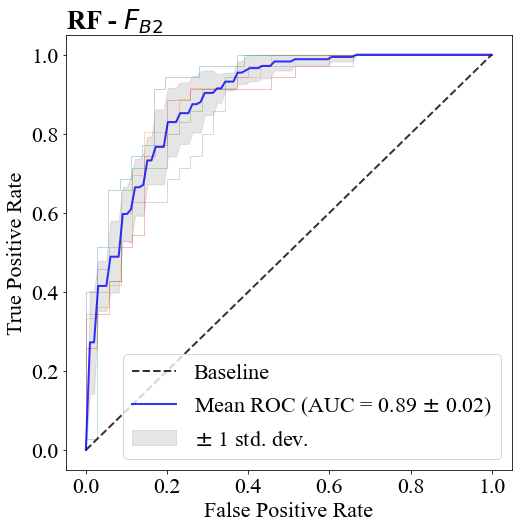

[0.831 0.803 0.8   0.843 0.743]
Accuracy - min: 0.7430, max: 0.8430, avg: 0.8040, std. dev: 0.0346
TPR - min: 0.7430, max: 0.9200, avg: 0.8342, std. dev: 0.0609
TNR - min: 0.7330, max: 0.8290, avg: 0.7854, std. dev: 0.0395
f1-score - min: 0.7430, max: 0.8430, avg: 0.8032, std. dev: 0.0347

 0.743  &  0.843  &  0.804 $\pm$ 0.035  &  0.743  &  0.92  &  0.834 $\pm$ 0.061  &  0.733  &  0.829  &  0.785 $\pm$ 0.04  &  0.743  &  0.843  &  0.803 $\pm$ 0.035


In [50]:
rf_acc, rf_cfm, rf_tpr, rf_tnr, rf_prec, rf_recall, rf_f1 = freq_feature_classification(x_train, y_train, 'RF', 0)

print(rf_acc)
print('Accuracy - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_acc), np.max(rf_acc), np.mean(rf_acc), np.std(rf_acc)))
print('TPR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_tpr), np.max(rf_tpr), np.mean(rf_tpr), np.std(rf_tpr)))
print('TNR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_tnr), np.max(rf_tnr), np.mean(rf_tnr), np.std(rf_tnr)))
# print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_prec), np.max(rf_prec), np.mean(rf_prec), np.std(rf_prec)))
# print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_recall), np.max(rf_recall), np.mean(rf_recall), np.std(rf_recall)))
print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_f1), np.max(rf_f1), np.mean(rf_f1), np.std(rf_f1)))

print('\n', np.min(rf_acc), ' & ', np.max(rf_acc), ' & ', np.around(np.mean(rf_acc),3), '$\pm$', np.around(np.std(rf_acc),3), ' & ', np.min(rf_tpr), ' & ',\
      np.max(rf_tpr), ' & ', np.around(np.mean(rf_tpr),3),'$\pm$', np.around(np.std(rf_tpr),3), ' & ', np.min(rf_tnr), ' & ', np.max(rf_tnr),' & ',\
      np.around(np.mean(rf_tnr),3),'$\pm$', np.around(np.std(rf_tnr),3), ' & ',np.min(rf_f1),' & ', np.max(rf_f1),' & ', np.around(np.mean(rf_f1),3),'$\pm$', np.around(np.std(rf_f1),3))

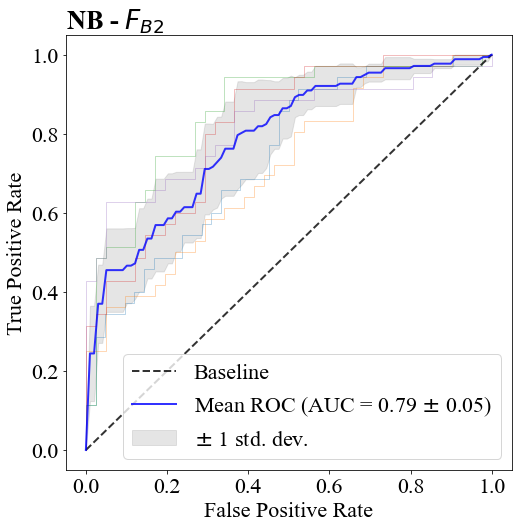

[0.649 0.649 0.737 0.697 0.763]
Accuracy - min: 0.6490, max: 0.7630, avg: 0.6990, std. dev: 0.0459
TPR - min: 0.6400, max: 0.7350, avg: 0.6816, std. dev: 0.0342
TNR - min: 0.6330, max: 0.8150, avg: 0.7376, std. dev: 0.0736
f1-score - min: 0.6370, max: 0.7550, avg: 0.6870, std. dev: 0.0464

 0.649  &  0.763  &  0.699 $\pm$ 0.046  &  0.64  &  0.735  &  0.682 $\pm$ 0.034  &  0.633  &  0.815  &  0.738 $\pm$ 0.074  &  0.637  &  0.755  &  0.687 $\pm$ 0.046


In [19]:
nb_acc, nb_cfm, nb_tpr, nb_tnr, nb_prec, nb_recall, nb_f1 = freq_feature_classification(x_train, y_train, 'NB',0)

print(nb_acc)
print('Accuracy - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_acc), np.max(nb_acc), np.mean(nb_acc), np.std(nb_acc)))
print('TPR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_tpr), np.max(nb_tpr), np.mean(nb_tpr), np.std(nb_tpr)))
print('TNR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_tnr), np.max(nb_tnr), np.mean(nb_tnr), np.std(nb_tnr)))
# print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_prec), np.max(nb_prec), np.mean(nb_prec), np.std(nb_prec)))
# print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_recall), np.max(nb_recall), np.mean(nb_recall), np.std(nb_recall)))
print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_f1), np.max(nb_f1), np.mean(nb_f1), np.std(nb_f1)))

print('\n', np.min(nb_acc), ' & ', np.max(nb_acc), ' & ', np.around(np.mean(nb_acc),3), '$\pm$', np.around(np.std(nb_acc),3), ' & ', np.min(nb_tpr), ' & ',\
      np.max(nb_tpr), ' & ', np.around(np.mean(nb_tpr),3),'$\pm$', np.around(np.std(nb_tpr),3), ' & ', np.min(nb_tnr), ' & ', np.max(nb_tnr),' & ',\
      np.around(np.mean(nb_tnr),3),'$\pm$', np.around(np.std(nb_tnr),3), ' & ',np.min(nb_f1),' & ', np.max(nb_f1),' & ', np.around(np.mean(nb_f1),3),'$\pm$', np.around(np.std(nb_f1),3))

### Individual classifiers - archived code

In [ ]:
# create Random Forest classifier
def RF_classifier(train_data, train_labels, test_data, test_labels):
    param_grid = {'n_estimators': [200], 'max_features': ['sqrt'], 'max_depth' : [10], 'criterion' :['gini'], 'random_state': [42]}
    clf = RandomForestClassifier()
    rf_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)

    # train model
    rf_clf.fit(train_data, train_labels)

    rf_clf.best_params_
    # print(rf_clf.best_params_)

    # predict model
    pred = (rf_clf.predict(test_data))

    # calculate accuracy
    acc = round(metrics.accuracy_score(test_labels, pred),4)
    cfm = metrics.confusion_matrix(test_labels, pred)
    tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

    # print("The predicted data is: ", pred)
    # print("The actual data is: ", np.array(val_labels))
    # print(f"The model is {acc*100}% accurate")

    return acc, tpr, tnr, cfm


rf_acc = []
rf_tpr = []
rf_tnr = []
rf_cfm = []

for ii in range(25):
    print('Random State: ', ii+1, end='\r')
    rs = np.linspace(1, 25, 25).astype(np.int)
    x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1), fft_df.labels, test_size=0.20, random_state=rs[ii]) #'peaks', 'variance', 'SNR', stratify=fft_df.labels
    temp_acc, temp_tpr, temp_tnr, temp_cfm = RF_classifier(x_train, y_train, x_test, y_test)
    rf_acc.append(temp_acc)
    rf_tpr.append(temp_tpr)
    rf_tnr.append(temp_tnr)
    rf_cfm.append(temp_cfm)


print("Random states: ", rs)
# print("Accuracy scores: ", svm_acc)
print("Average accuracy: ", np.mean(rf_acc))
print("Standard deviation: ", np.std(rf_acc))
print("Average TNR: ", np.mean(rf_tnr))
print("Average TPR: ", np.mean(rf_tpr))

In [ ]:
# Create Naive Bayes Classifier
def NB_classifier(train_data, train_labels, test_data, test_labels):
    
    # train model
    nb_clf = GaussianNB()
    nb_clf.fit(x_train, y_train)

    # predict model
    pred = (nb_clf.predict(x_test))

    # calculate accuracy
    acc = round(metrics.accuracy_score(y_test, pred),4)
    cfm = metrics.confusion_matrix(y_test, pred)
    tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

    return acc, tpr, tnr, cfm
    
nb_acc = []
nb_tpr = []
nb_tnr = []
nb_cfm = []

for ii in range(25):
    print('Random State: ', ii+1, end='\r')
    rs = np.linspace(1, 25, 25).astype(np.int)
    x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels'], axis=1), fft_df.labels, test_size=0.20, random_state=rs[ii]) #'peaks', 'variance', 'SNR', stratify=fft_df.labels

    temp_acc, temp_tpr, temp_tnr, temp_cfm = NB_classifier(x_train, y_train, x_test, y_test)

    nb_acc.append(temp_acc)
    nb_tpr.append(temp_tpr)
    nb_tnr.append(temp_tnr)
    nb_cfm.append(temp_cfm)


print("Random states: ", rs)
# print("Accuracy scores: ", svm_acc)
print("Average accuracy: ", np.mean(nb_acc))
print("Standard deviation: ", np.std(nb_acc))
print("Average TNR: ", np.mean(nb_tnr))
print("Average TPR: ", np.mean(nb_tpr))

In [ ]:
# create SVM classifier
def SVM_classifier(train_data, train_labels, val_data, val_labels):
    cv_acc = []
    
    # convert labels to an array
    val_labels = np.array(val_labels)
    #clf = svm.SVC(kernel='poly', degree=5)
    param_grid={'C':[100],'degree':[7],'kernel':['poly']}
    clf = svm.SVC(probability=True)
    svm_clf = GridSearchCV(clf, param_grid, cv=5)

    # train model
    svm_clf.fit(train_data, train_labels)
    # print(model.cv_results_.keys())
    # print(svm_clf.cv_results_)

    svm_clf.best_params_
    # print(svm_clf.best_params_)

    # predict the model
    pred = (svm_clf.predict(val_data))

    # calculate accuracy
    acc = round(metrics.accuracy_score(val_labels, pred),4)
    cfm = metrics.confusion_matrix(val_labels, pred)
    tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

    # compute info for ROC curve
    y_score = svm_clf.predict_proba(val_data)
    xaxis, yaxis, _ = metrics.roc_curve(val_labels, y_score[:,1], pos_label=1, drop_intermediate=False)

    # print("The predicted data is: ", pred)
    # print("The actual data is: ", np.array(val_labels))
    # print(f"The model is {acc*100}% accurate")

    return acc, tpr, tnr, cfm, xaxis, yaxis

svm_acc = []
svm_tpr = []
svm_tnr = []
svm_cfm = []
svm_xaxis = []
svm_yaxis = []

for ii in range(1):
    print('Random State: ', ii+1, end='\r')
    rs = np.linspace(1, 50, 50).astype(np.int)
    x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1), fft_df.labels, test_size=0.20, random_state=rs[42]) #'peaks', 'variance', 'SNR', stratify=fft_df.labels
    temp_acc, temp_tpr, temp_tnr, temp_cfm, temp_xaxis, temp_yaxis = SVM_classifier(x_train, y_train, x_test, y_test)
    # svm_acc.append(temp_acc)
    # svm_tpr.append(temp_tpr)
    # svm_tnr.append(temp_tnr)
    # svm_cfm.append(temp_cfm)

    # svm_xaxis.append(temp_xaxis)
    # svm_yaxis.append(temp_yaxis)


# print("Accuracy scores: ", svm_acc)
print("Average accuracy: ", np.mean(svm_acc))
print("Standard deviation: ", np.std(svm_acc))
print("Average TNR: ", np.mean(svm_tnr))
print("Average TPR: ", np.mean(svm_tpr))

## <center>Step 5: Regression<center>

In [30]:
# Lasso Regression
# drop features of choice
x_train = fft_df.drop(['labels'], axis=1)
y_train = fft_df.labels

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# lasso = LassoCV(n_alphas=1000, cv=None, random_state=2)
# lasso.fit(x_train, y_train)
# print(lasso.alpha_)

lasso = Lasso(alpha=0.5, random_state=42, max_iter=100)
results = pd.DataFrame(columns=['prediction', 'actual', 'img_name', 'img_num'])
feat_info = pd.DataFrame(columns=['peaks', 'centers', 'variance', 'SNR', 'BW', 'img_num']) #'hist', 'thresh_val'
for train, test in cv.split(x_train, y_train):
    lasso.fit(x_train.iloc[train[:]], y_train.iloc[train[:]])
    probas_ = lasso.predict(x_train.iloc[test[:]])
    # print(lasso.score(x_train.iloc[test[:]], y_train.iloc[test[:]]))

    y_test =  y_train.iloc[test[:]]
    for i in range(len(probas_)):
        # print(i)
        tempdf = pd.DataFrame(columns=['prediction', 'actual', 'img_name', 'img_num'])
        tempdf.loc[0] = [probas_[i], np.array(y_test)[i], img_names[y_test.index[i]], y_test.index[i]]
        results = results.append(tempdf)

    featdf = x_train.iloc[test[:]].astype(np.float)
    featdf['img_num'] = y_test.index
    feat_info = feat_info.append(featdf)


results = results.sort_values("img_num")
feat_info = feat_info.sort_values("img_num")

In [31]:
# bound result predictions between 0 and 1
temp = results['prediction']
temp = temp + np.abs(np.min(temp)) # adjust the minimum to be zero
temp = temp / np.max(temp) # normalize maximum to be 1
temp = np.around(temp, 3) # round to 3 decimal places
results['prediction'] = temp
# results.to_excel('results_freq_only.xlsx')

In [17]:
# feat_info.to_excel('feat_info_freq_only.xlsx')

In [39]:
# calculate the correlation between features
from scipy.stats import pearsonr, spearmanr, kendalltau
feat = ['peaks', 'centers', 'variance', 'SNR', 'BW', 'hist', 'thresh_val']
corr = []

data1 = np.array(results['prediction']) # regression prediction values
# data1 = np.around(np.array(feat_info['SNR']).astype(np.float),4)
for i in feat:
    data2 = np.around(np.array(feat_info[i]).astype(np.float),4)
    corr, p = kendalltau(data1, data2)
    print(i, ': \n', 'correlation: ', np.around(corr, 4), 'p-value: ', p)

feat_corr = feat_info.drop(['img_num'], axis=1)
feat_corr['pred'] = np.array(results['prediction'])
feat_corr.corr('spearman')

peaks : 
 correlation:  -0.1834 p-value:  2.868381222583209e-07
centers : 
 correlation:  0.3056 p-value:  7.05924899453998e-17
variance : 
 correlation:  0.0183 p-value:  0.6160127095503212
SNR : 
 correlation:  -0.0615 p-value:  0.08537771975270708
BW : 
 correlation:  0.4587 p-value:  3.6283697546065693e-37
hist : 
 correlation:  0.4017 p-value:  2.6142133520960575e-29
thresh_val : 
 correlation:  -0.1001 p-value:  0.005109009236060042


,peaks,centers,variance,SNR,BW,hist,thresh_val,pred
peaks,1.000000,-0.390817,0.618437,0.114930,-0.325685,-0.021689,0.075184,-0.269703
centers,-0.390817,1.000000,-0.135792,-0.031045,0.332912,0.186865,-0.032194,0.432980
variance,0.618437,-0.135792,1.000000,0.218076,-0.193244,0.150276,0.091574,0.021339
SNR,0.114930,-0.031045,0.218076,1.000000,-0.750736,-0.092649,-0.095635,-0.093829
BW,-0.325685,0.332912,-0.193244,-0.750736,1.000000,0.219671,0.089071,0.622231
hist,-0.021689,0.186865,0.150276,-0.092649,0.219671,1.000000,-0.272978,0.567368
thresh_val,0.075184,-0.032194,0.091574,-0.095635,0.089071,-0.272978,1.000000,-0.143207
pred,-0.269703,0.432980,0.021339,-0.093829,0.622231,0.567368,-0.143207,1.000000


In [32]:
# calculate kendall rank correlation coeff
from scipy.stats import kendalltau
#p2-1, p9-2, p13-2, 'p16-1','p16-2'

eval_scores_indiv = [0.4167,0.4861, 0.2917,0.3472,0.3472,0.3750,0.3056,0.5278,0.5278,0.4722,0.4167,0.2778,0.3056,\
0.2778,0.3333,0.3333, 0.3056,0.2778,0.3333,0.3333,0.3889,0.4583,0.3472, 0.3333,0.3611,0.1111,0.1667, 0.1806,0.1667,\
0.3611,0.4167,0.2083,0.2361,0.2222,0.2778]
eval_scores_avg = [0.4514,0.2917,0.3472,0.3403,0.5278,0.4444,0.2917,0.3056,0.3333,0.2917,0.3333,0.4236,0.3472,0.3472,\
0.1389, 0.1736,0.3889,0.2222,0.2500]

reg_score_indiv = [0.5735,0.5768, 0.4682,0.3852,0.5370,0.4286,0.4335,0.5743,0.5413,0.6083,0.8700,0.4185,0.4248,0.4624,\
    0.4720,0.6670, 0.6085,0.3977,0.5067,0.4945,0.7553,0.5527,0.3020, 0.8558,0.7080,0.3798,0.3988, 0.4380,0.3773,0.3513,\
    0.6710,0.3028,0.4003,0.3352,0.3677]
reg_score_avg = [0.5752,0.4682,0.4611,0.4311,0.5578,0.7392,0.4217,0.4672,0.6670,0.5031,0.5006,0.6540,0.3020,0.7819,0.3893,\
    0.4077,0.5112,0.3515,0.3514]

reg_score_freq_only_indiv = [0.6475, 0.5885, 0.5346, 0.2962, 0.4483, 0.3950, 0.3772, 0.5950, 0.4915, 0.5747, 0.6298, 0.4122,\
    0.3942, 0.3946, 0.5252, 0.7770, 0.6043, 0.3688, 0.6307, 0.5048, 0.7710, 0.5577, 0.3755, 0.8805, 0.6344, 0.3775, 0.4038,\
    0.4777, 0.3648, 0.3763, 0.7040, 0.3483, 0.4300, 0.3915, 0.3748]
reg_score_freq_only_avg = [0.6180, 0.5346, 0.3723, 0.3861, 0.5433, 0.6023, 0.4032, 0.4599, 0.7770, 0.4866, 0.5677, 0.6643,\
    0.3755, 0.7575, 0.3907, 0.4213, 0.5402, 0.3892, 0.3832]

corr_indiv_freq_only,_ = kendalltau(reg_score_freq_only_indiv, eval_scores_indiv)
corr_indiv_all,_       = kendalltau(reg_score_indiv, eval_scores_indiv)

corr_avg_freq_only,_   = kendalltau(reg_score_freq_only_avg, eval_scores_avg)
corr_avg_all,_         = kendalltau(reg_score_avg, eval_scores_avg)

print('Kendall Rank Corr - Frequency Only: ', corr_indiv_freq_only)
print('Kendall Rank Corr - All: ', corr_indiv_all)
print('Kendall Rank Corr - Frequency Only Avg: ', corr_avg_freq_only)
print('Kendall Rank Corr - All Avg: ', corr_avg_all)

Kendall Rank Corr - Frequency Only:  0.3529424115303533
Kendall Rank Corr - All:  0.45624262953923717
Kendall Rank Corr - Frequency Only Avg:  0.29857265162500773
Kendall Rank Corr - All Avg:  0.4657733365350121


In [38]:
from scipy.stats import pearsonr, spearmanr

corr_indiv_freq_only,_ = spearmanr(reg_score_freq_only_indiv, eval_scores_indiv)
corr_indiv_all,_       = spearmanr(reg_score_indiv, eval_scores_indiv)

corr_avg_freq_only,_   = spearmanr(reg_score_freq_only_avg, eval_scores_avg)
corr_avg_all,_         = spearmanr(reg_score_avg, eval_scores_avg)

print('Kendall Rank Corr - Frequency Only: ', corr_indiv_freq_only)
print('Kendall Rank Corr - All: ', corr_indiv_all)
print('Kendall Rank Corr - Frequency Only Avg: ', corr_avg_freq_only)
print('Kendall Rank Corr - All Avg: ', corr_avg_all)

Kendall Rank Corr - Frequency Only:  0.5278565188064441
Kendall Rank Corr - All:  0.621007669184052
Kendall Rank Corr - Frequency Only Avg:  0.46059366536945173
Kendall Rank Corr - All Avg:  0.6534617585165071


In [ ]:
# Perform Logistic Regression 
# Use the prediction probabilities as the regression results
# Compare results using L1, L2, and L1 + L2 

# set x_train and y_train, drop features of choice
x_train = fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1)
y_train = fft_df.labels
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# create the model
clf = LogisticRegression(penalty='l1', C=1.0, fit_intercept=True, random_state=42, solver='liblinear')

i = 0
results = pd.DataFrame(columns=['prediction', 'actual', 'img_num'])
acc = []
for train, test in cv.split(x_train, y_train):
    print(len(test))
    probas_ = clf.fit(x_train.iloc[train[:]], y_train.iloc[train[:]]).predict_proba(x_train.iloc[test[:]])
    for i in range(len(probas_)):
        # print(i)
        tempdf = pd.DataFrame(columns=['prediction', 'actual', 'img_num'])
        tempdf.loc[0] = [probas_[i][1], np.array(y_test)[i], img_names[y_test.index[i]]]
        results = results.append(tempdf)

        pred = (clf.predict(x_train.iloc[test[:]]))

    # calculate accuracy
    acc.append(round(metrics.accuracy_score(y_train.iloc[test[:]], pred),4))
    
    # print(probas_)

print(acc)

In [ ]:
# Perform Logistic Regression 
# Use the prediction probabilities as the regression results
# Compare results using L1, L2, and L1 + L2 

# set x_train and y_train, drop features of choice
x_train = fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1)
y_train = fft_df.labels
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# create the model
clf = LogisticRegression(penalty='l1', C=1.0, fit_intercept=True, random_state=42, solver='liblinear')

i = 0
results = pd.DataFrame(columns=['prediction', 'actual', 'img_num'])
acc = []
for train, test in cv.split(x_train, y_train):
    print(len(test))
    probas_ = clf.fit(x_train.iloc[train[:]], y_train.iloc[train[:]]).predict_proba(x_train.iloc[test[:]])
    for i in range(len(probas_)):
        # print(i)
        tempdf = pd.DataFrame(columns=['prediction', 'actual', 'img_num'])
        tempdf.loc[0] = [probas_[i][1], np.array(y_test)[i], img_names[y_test.index[i]]]
        results = results.append(tempdf)

        pred = (clf.predict(x_train.iloc[test[:]]))

    # calculate accuracy
    acc.append(round(metrics.accuracy_score(y_train.iloc[test[:]], pred),4))
    
    # print(probas_)

print(acc)

77


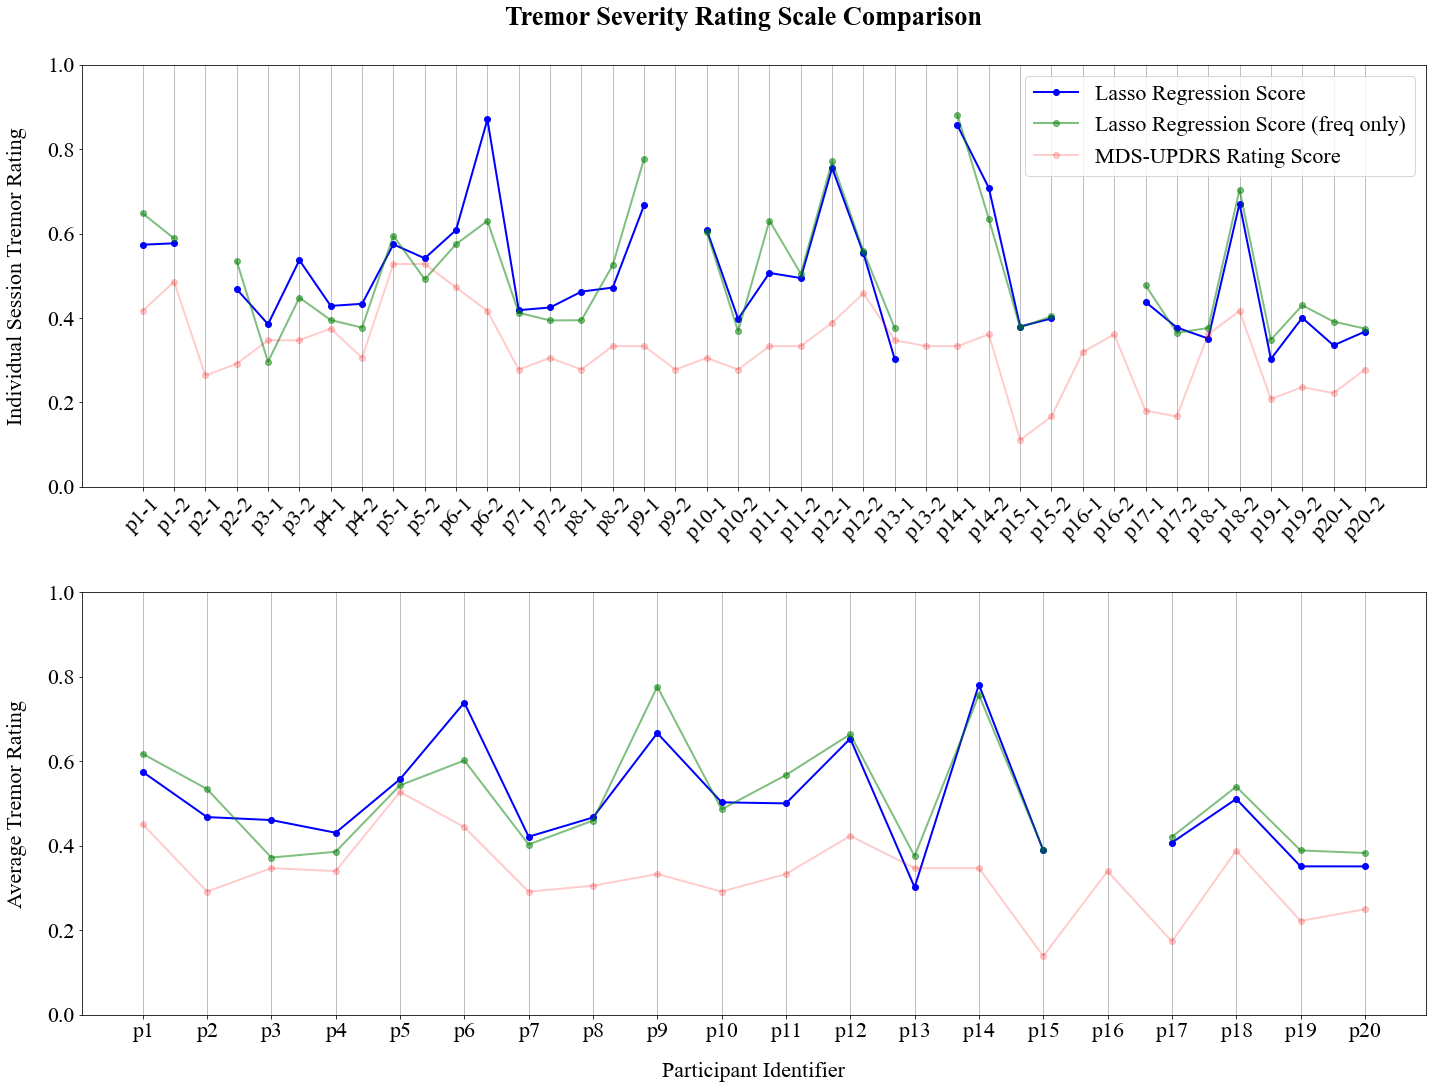

In [27]:
# individual scores
eval_scores_indiv = [0.4167,0.4861, 0.2639, 0.2917,0.3472,0.3472,0.3750,0.3056,0.5278,0.5278,0.4722,0.4167,0.2778,0.3056,\
0.2778,0.3333,0.3333, 0.2778, 0.3056,0.2778,0.3333,0.3333,0.3889,0.4583,0.3472, 0.3333, 0.3333,0.3611,0.1111,0.1667, 0.3194, 0.3611, 0.1806,0.1667,\
0.3611,0.4167,0.2083,0.2361,0.2222,0.2778]
# eval_scores_indiv = np.around(eval_scores_indiv / np.max(eval_scores_indiv), 4)
eval_scores_avg = [0.4514,0.2917,0.3472,0.3403,0.5278,0.4444,0.2917,0.3056,0.3333,0.2917,0.3333,0.4236,0.3472,0.3472,\
0.1389,0.3401, 0.1736,0.3889,0.2222,0.2500]
# eval_scores_avg = np.around(eval_scores_avg / np.max(eval_scores_avg), 4)

reg_score_indiv = [0.5735,0.5768, np.nan, 0.4682,0.3852,0.5370,0.4286,0.4335,0.5743,0.5413,0.6083,0.8700,0.4185,0.4248,0.4624,\
    0.4720,0.6670, np.nan, 0.6085,0.3977,0.5067,0.4945,0.7553,0.5527,0.3020, np.nan, 0.8558,0.7080,0.3798,0.3988, np.nan, np.nan, 0.4380,0.3773,0.3513,\
    0.6710,0.3028,0.4003,0.3352,0.3677]
reg_score_avg = [0.5752,0.4682,0.4611,0.4311,0.5578,0.7392,0.4217,0.4672,0.6670,0.5031,0.5006,0.6540,0.3020,0.7819,0.3893,np.nan,\
    0.4077,0.5112,0.3515,0.3514]

reg_score_freq_only_indiv = [0.6475, 0.5885, np.nan, 0.5346, 0.2962, 0.4483, 0.3950, 0.3772, 0.5950, 0.4915, 0.5747, 0.6298, 0.4122,\
    0.3942, 0.3946, 0.5252, 0.7770, np.nan, 0.6043, 0.3688, 0.6307, 0.5048, 0.7710, 0.5577, 0.3755, np.nan, 0.8805, 0.6344, 0.3775, 0.4038,\
    np.nan, np.nan, 0.4777, 0.3648, 0.3763, 0.7040, 0.3483, 0.4300, 0.3915, 0.3748]
reg_score_freq_only_avg = [0.6180, 0.5346, 0.3723, 0.3861, 0.5433, 0.6023, 0.4032, 0.4599, 0.7770, 0.4866, 0.5677, 0.6643,\
    0.3755, 0.7575, 0.3907, np.nan, 0.4213, 0.5402, 0.3892, 0.3832]


x_avg = ['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15', 'p16', 'p17','p18','p19','p20']
x_indiv=['p1-1','p1-2','p2-1','p2-2','p3-1','p3-2','p4-1','p4-2','p5-1','p5-2','p6-1','p6-2','p7-1','p7-2','p8-1','p8-2',\
    'p9-1', 'p9-2', 'p10-1','p10-2','p11-1','p11-2','p12-1','p12-2','p13-1','p13-2', 'p14-1','p14-2','p15-1','p15-2','p16-1','p16-2', 'p17-1','p17-2','p18-1',\
    'p18-2','p19-1','p19-2','p20-1','p20-2'] #p2-1, p9-2, p13-2, 'p16-1','p16-2'

linewidth=2
msize=6
fig, ax = plt.subplots(2,1,figsize=(20,15))
fig.suptitle('Tremor Severity Rating Scale Comparison', va='top', weight='bold')
fig.tight_layout()
ax[0].plot(x_indiv, reg_score_indiv, label="Lasso Regression Score", color='b', marker='o', linestyle='solid', alpha=1, linewidth=linewidth, markersize=msize)
ax[0].plot(x_indiv, reg_score_freq_only_indiv, label="Lasso Regression Score (freq only)", color='g', marker='o', linestyle='solid', alpha=0.5, linewidth=linewidth, markersize=msize)
ax[0].plot(x_indiv, eval_scores_indiv, label="MDS-UPDRS Rating Score", color='r', marker='o', linestyle='solid', alpha=0.2, linewidth=linewidth, markersize=msize)
ax[0].legend(loc="upper right")
ax[0].grid(axis='x')
ax[1].plot(x_avg, reg_score_avg, color='b', marker='o', linestyle='solid', alpha=1, linewidth=linewidth, markersize=msize)
ax[1].plot(x_avg, reg_score_freq_only_avg, color='g', marker='o', linestyle='solid', alpha=0.5, linewidth=linewidth, markersize=msize)
ax[1].plot(x_avg, eval_scores_avg, color='r', marker='o', linestyle='solid', alpha=0.2, linewidth=linewidth, markersize=msize)

ax[1].grid(axis='x')


ax[0].set_ylim([0, 1.0])
ax[1].set_ylim([0, 1.0])
ax[1].set_xlabel('Participant Identifier', labelpad=20)
ax[1].set_ylabel('Average Tremor Rating', labelpad=20)
ax[0].set_ylabel('Individual Session Tremor Rating', labelpad=20)
ax[0].set_xticklabels(x_indiv, rotation=45)
plt.subplots_adjust(hspace=.25)
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()


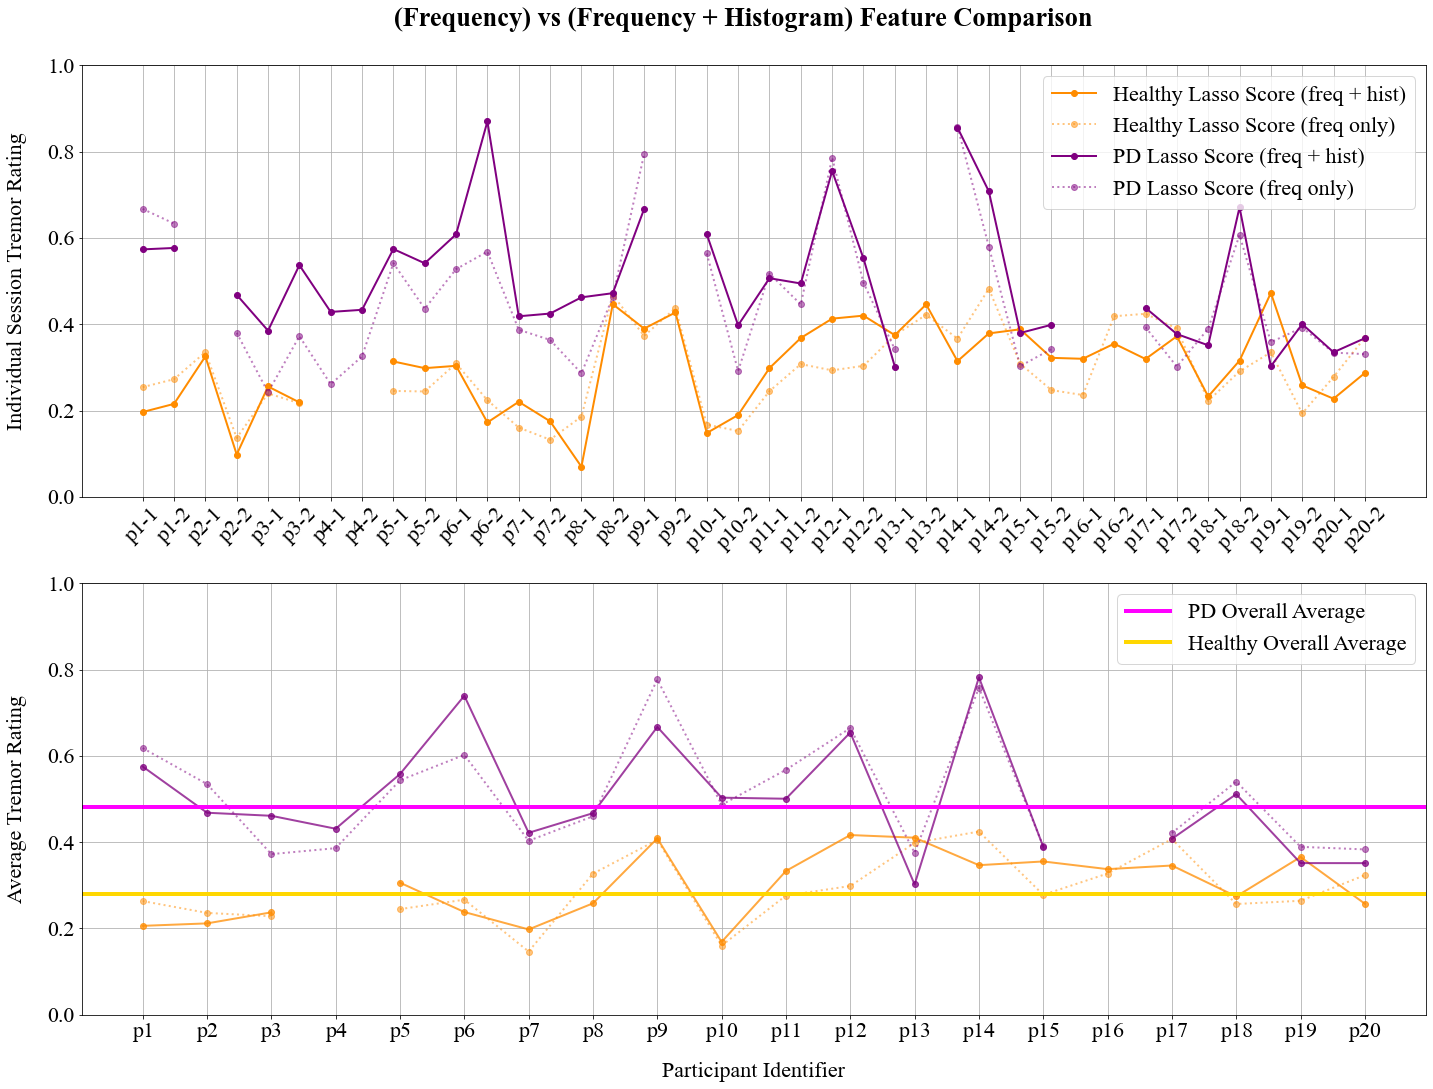

In [22]:
healthy_score1 = [0.1967, 0.2155, 0.3255, 0.0982,0.2558,0.2190,np.nan, np.nan, 0.3138,0.2983,0.3037,0.1725,0.2204,0.1752,\
    0.0700,0.4465,0.3900,0.4273,0.1480,0.1897,0.2984,0.3682,0.4130,0.4200,0.3748,0.4460,0.3145,0.3788,\
    0.3883,0.3222,0.3200,0.3550,0.3195,0.3722,0.2327,0.3157,0.4726,0.2585,0.2275,0.2872]
healthy_score1_avg = [0.2061,0.2118,0.2374,np.nan,0.3061, 0.2381,0.1978,0.2583,0.4087,0.1688,0.3333,0.4165,\
    0.4104,0.3467,0.3553,0.3375,0.3459,0.2742,0.3656,0.2573]
healthy_score2 = [0.2543,0.2727,0.3355,0.1367,0.2398,0.2170,np.nan, np.nan, 0.2455,0.2443,0.3093,0.2240,0.1606,0.1326,\
    0.1860,0.4680,0.3730,0.4375,0.1677,0.1527,0.2450,0.3077,0.2932,0.3037,0.3745,0.4220,0.3668,0.4823,\
    0.3085,0.2474,0.2360,0.4186,0.4243,0.3902,0.2225,0.2908,0.3350,0.1933,0.2780,0.3692]
healthy_score2_avg = [0.2635,0.2361,0.2284,np.nan, 0.2449,0.2667,0.1466,0.3270,0.4053,0.1602,0.2763,0.2984,0.3983,\
    0.4246,0.2780,0.3273,0.4073,0.2567,0.2642,0.3236]

# -----------------------------------------
pd_score1 = [0.5735, 0.5768, np.nan, 0.4682, 0.3852, 0.5370, 0.4286, 0.4335, 0.5743, 0.5413, 0.6083, 0.8700, 0.4185,\
    0.4248, 0.4624, 0.4720, 0.6670, np.nan, 0.6085, 0.3977, 0.5067, 0.4945, 0.7553, 0.5527, 0.3020,np.nan, 0.8558, 0.7080, 0.3798, 0.3988,\
    np.nan, np.nan, 0.4380, 0.3773, 0.3513, 0.6710,0.3028,0.4003,0.3352,0.3677]
pd_score2 = [0.6672, 0.6333, np.nan, 0.3802, 0.2422, 0.3723, 0.2610, 0.3255, 0.5415, 0.4360, 0.5277, 0.5683, 0.3873,\
    0.3638, 0.2864, 0.4627, 0.7940, np.nan, 0.5640, 0.2917, 0.5173, 0.4460, 0.7860, 0.4962, 0.3420,np.nan, 0.8580, 0.5800, 0.3030, 0.3426,\
    np.nan, np.nan, 0.3932, 0.3018, 0.3897, 0.6070, 0.3585, 0.3923, 0.3343, 0.3308]
pd_score1_avg = [0.5752,0.4682,0.4611,0.4311,0.5578,0.7392,0.4217,0.4672,0.6670,0.5031,0.5006,0.6540,0.3020,0.7819,0.3893,\
    np.nan, 0.4077,0.5112,0.3515,0.3514]
pd_score2_avg = [0.6180, 0.5346, 0.3723, 0.3861, 0.5433, 0.6023, 0.4032, 0.4599, 0.7770, 0.4866, 0.5677, 0.6643,\
    0.3755, 0.7575, 0.3907,np.nan, 0.4213, 0.5402, 0.3892, 0.3832]

x_avg = ['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15','p16','p17','p18','p19','p20']
x_indiv=['p1-1','p1-2','p2-1','p2-2','p3-1','p3-2','p4-1','p4-2','p5-1','p5-2','p6-1','p6-2','p7-1','p7-2','p8-1','p8-2',\
    'p9-1','p9-2','p10-1','p10-2','p11-1','p11-2','p12-1','p12-2','p13-1','p13-2','p14-1','p14-2','p15-1','p15-2','p16-1','p16-2','p17-1','p17-2','p18-1',\
    'p18-2','p19-1','p19-2','p20-1','p20-2']

# line of best fit
x_num_line = np.linspace(1,20,20)
y_total_pd = np.nan_to_num(np.array(pd_score1_avg) + np.array(pd_score2_avg)) / 2
a_pd,b_pd = np.polyfit(x_num_line, y_total_pd, 1)

y_total_h = np.nan_to_num(np.array(healthy_score1_avg) + np.array(healthy_score2_avg)) / 2
a_h,b_h = np.polyfit(x_num_line, y_total_h, 1)

linewidth=2
msize=6
fig, ax = plt.subplots(2,1,figsize=(20,15))
fig.suptitle('(Frequency) vs (Frequency + Histogram) Feature Comparison', va='top', weight='bold')
fig.tight_layout()
ax[0].plot(x_indiv, healthy_score1, label="Healthy Lasso Score (freq + hist)", color='darkorange', marker='o', linestyle='solid', alpha=1, linewidth=linewidth, markersize=msize)
ax[0].plot(x_indiv, healthy_score2, label="Healthy Lasso Score (freq only)", color='darkorange', marker='o', linestyle='dotted', alpha=0.5, linewidth=linewidth,markersize=msize)
ax[0].plot(x_indiv, pd_score1, label="PD Lasso Score (freq + hist)", color='purple', marker='o', linestyle='solid', alpha=1, linewidth=linewidth,markersize=msize)
ax[0].plot(x_indiv, pd_score2, label="PD Lasso Score (freq only)", color='purple', marker='o', linestyle='dotted', alpha=0.5, linewidth=linewidth,markersize=msize)
ax[0].legend(loc="upper right")
ax[0].grid()

ax[1].plot(x_avg, healthy_score1_avg, color='darkorange', marker='o', linestyle='solid', alpha=.75, linewidth=linewidth,markersize=msize)
ax[1].plot(x_avg, healthy_score2_avg, color='darkorange', marker='o', linestyle='dotted', alpha=0.5, linewidth=linewidth,markersize=msize)
ax[1].plot(x_avg, pd_score1_avg, color='purple', marker='o', linestyle='solid', alpha=.75, linewidth=linewidth,markersize=msize)
ax[1].plot(x_avg, pd_score2_avg, color='purple', marker='o', linestyle='dotted', alpha=0.5, linewidth=linewidth,markersize=msize)
# ax[1].plot(x_avg, a_pd*x_num_line+b_pd, color='gold', linewidth=linewidth+2, alpha=0.2, label='PD Best-Fit Line')
# ax[1].plot(x_avg, a_h*x_num_line+b_h, color='fuchsia', linewidth=linewidth+2, alpha=0.2, label='Healthy Best-Fit Line')
ax[1].axhline(y=np.mean(y_total_pd), color='fuchsia', linewidth=linewidth+2, alpha=1, label='PD Overall Average')
ax[1].axhline(y=np.mean(y_total_h),  color='gold', linewidth=linewidth+2, alpha=1, label='Healthy Overall Average')
ax[1].legend(loc='upper right')
ax[1].grid()

ax[0].set_ylim([0, 1.0])
ax[1].set_ylim([0, 1.0])
ax[1].set_xlabel('Participant Identifier', labelpad=20,)
ax[1].set_ylabel('Average Tremor Rating', labelpad=20)
ax[0].set_ylabel('Individual Session Tremor Rating', labelpad=20)
ax[0].set_xticklabels(x_indiv, rotation=45)
plt.subplots_adjust(hspace=.2)
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()